# **Imágenes máximas con las que podemos trabajar**
***


En este código se estudiará el número máximo de imagenes con las que podemos trabajar.

<a id="1"></a>
## 1. Carga de datos

Importacion de librerias

In [1]:
#instalacion
!pip install memory-profiler
!pip install glob2
!pip install Pillow
%load_ext memory_profiler
#importacion librerias
import numpy as np
import seaborn as sns
from google.colab import drive
import os
import glob
import cv2
import tensorflow as tf
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers, Model
from keras.models import load_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import Sequence, load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
from datetime import timedelta
import matplotlib.image as mpimg
from __future__ import annotations
from scipy.cluster.hierarchy import linkage, dendrogram
from dataclasses import dataclass
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import numpy as np
from functools import reduce
import timeit
from datetime import datetime
from keras.preprocessing import image
from typing import Union
import time

In [3]:
#conexion drive
drive.mount('/content/drive')

Mounted at /content/drive


Carga de la red neuronal preentrenada

In [10]:
resnset50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

<a id="2"></a>
## 2. Definición de  funciones de la red

Funciones requeridas por la red neuornal siamesa.

In [11]:
def get_celebrities(n_celebrities:int, refactor_class=False):
    df1, df2 = get_max_aparicions(get_identities(), n_celebrities)
    #df.reset_index(inplace=True, drop=True)
    if refactor_class:
        df1 = refactor_identity(df1, 'Identity')
    return df1, df2


def get_max_aparicions(df:pd.DataFrame, n_celebrities:int):
    aparicions_df = df["Identity"].value_counts()
    aparicions_df = aparicions_df.reset_index()
    aparicions_df = aparicions_df.rename(columns={'Identity':'aparicions', 'index':'Identity'})
    aparicions_df = aparicions_df.iloc[:n_celebrities]
    return df[df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True), df[~df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True)

def get_identities():
    identity_df = pd.read_csv("/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Anno/identity_CelebA.txt", sep=' ', header=None)
    identity_df = identity_df.rename(columns={0:"Image_name", 1:"Identity"})
    return identity_df

def refactor_identity(df, traget_col):
    d = get_dic_index(df, traget_col)
    df["Class"] = df.apply(lambda row: d[row[traget_col]], axis=1)
    return df

def get_dic_index(df, traget_col):
    df = df[traget_col].value_counts()
    dic_index = df.to_dict()
    i = 0
    for c in dic_index:
        dic_index[c] = i
        i += 1
    return dic_index
def get_tvt(df:pd.DataFrame, target_name:str, train_size:int):
    total_classes = df[target_name].nunique()
    n_df_col = df.shape[0]
    df = shuffle(df)
    train_df = df.iloc[:int(n_df_col*train_size)]
    val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
    test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]
    while True:
        if train_df[target_name].nunique() == total_classes and val_df[target_name].nunique() == total_classes and test_df[target_name].nunique() == total_classes:
            return train_df, val_df, test_df

        df = shuffle(df)
        train_df = df.iloc[:int(n_df_col*train_size)]
        val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
        test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]
class DataGenerator(Sequence):
  def __init__(self, df, batch_size=32, img_size=(200,200), img_dir= './', shuffle=True):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_dir = img_dir
    self.df = df
    self.indices = self.df.index.tolist()
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return len(self.indices) // self.batch_size

  def __getitem__(self, index):
    index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
    batch = [self.indices[k] for k in index]

    X1, X2, y = self.__get_data(batch)
    return [X1, X2], y

  def on_epoch_end(self):
    self.index = np.arange(len(self.indices))
    if self.shuffle:
      np.random.shuffle(self.index)

  def __get_data(self, batch):
    X1 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    X2 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    y = np.zeros((self.batch_size,), dtype="float32")
    for i, idx in enumerate(batch):
      X1[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image1'], target_size=self.img_size))
      X2[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image2'], target_size=self.img_size))
      y[i] = self.df.loc[idx,'Sim']
    return X1, X2, y


class EuclideanDLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, x, y):
        sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
        return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [12]:
 def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

Carga de la red neuronal entrenada

In [13]:
siamese = load_model('/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/Weights/2023-10-07 10h 33m_test_8.best',
                     custom_objects={'KerasLayer': hub.KerasLayer,
                                     'EuclideanDLayer': EuclideanDLayer,
                                     'contrastive_loss': contrastive_loss})

<a id="3"></a>
## 3. Tiempo creación matriz similitud

Calculo tiempo ejecución para crear matriz de similiutd compuesta por el numero de imagenes establecido

In [14]:
def generar_matriz_similitud(directorio_imagenes, nombres_imagenes, num_imagenes_a_comparar):
    similarity_matrix = np.zeros((num_imagenes_a_comparar, num_imagenes_a_comparar), dtype=np.float32)
    start_time = time.time()
    for i in range(num_imagenes_a_comparar):
        img1 = image.load_img(os.path.join(directorio_imagenes, nombres_imagenes[i]), target_size=(178, 218))
        img1 = image.img_to_array(img1)
        img1 = np.expand_dims(img1, axis=0)

        for j in range(i + 1, num_imagenes_a_comparar):
            img2 = image.load_img(os.path.join(directorio_imagenes, nombres_imagenes[j]), target_size=(178, 218))
            img2 = image.img_to_array(img2)
            img2 = np.expand_dims(img2, axis=0)
            embedding1 = siamese.predict([img1, img2])
            similarity_matrix[i, j] = embedding1
            similarity_matrix[j, i] = embedding1
        del img1
    elapsed_time = round(time.time() - start_time, 2)
    elapsed_time_str = str(timedelta(seconds=elapsed_time))
    df1 = pd.DataFrame(similarity_matrix, index=nombres_imagenes[:num_imagenes_a_comparar], columns=nombres_imagenes[:num_imagenes_a_comparar])
    df_tiempo = pd.DataFrame({f't_matriz_similitud (hh:mm:ss.sss)': [elapsed_time_str]}, index=[f'Iteración_{num_imagenes_a_comparar}'])

    return df1, df_tiempo

In [ ]:
import gc
gc.collect()
directorio_imagenes = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/cut_faces/'
num_imagenes_a_comparar = 265
nombres_imagenes = os.listdir(directorio_imagenes)
df1, df_tiempo = generar_matriz_similitud(directorio_imagenes, nombres_imagenes, num_imagenes_a_comparar)
df_tiempo

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 27ms/step


In [ ]:
df1

,115535.jpg,115410.jpg,115717.jpg,115591.jpg,116076.jpg,115819.jpg,116199.jpg,116077.jpg,116278.jpg,116269.jpg,...,128953.jpg,128731.jpg,128987.jpg,129000.jpg,129009.jpg,129094.jpg,129248.jpg,129112.jpg,129311.jpg,129371.jpg
115535.jpg,0.000000,0.457503,0.991875,0.901704,0.490327,0.678429,0.320739,0.368646,0.921700,0.192415,...,0.937850,0.134993,0.391509,0.088825,0.523629,0.952717,0.957311,0.055744,0.132234,0.047533
115410.jpg,0.457503,0.000000,0.758971,0.792353,0.129712,0.984788,0.944355,0.681006,0.292574,0.661242,...,0.586516,0.261845,0.891875,0.295789,0.753851,0.268346,0.998036,0.190473,0.273834,0.265675
115717.jpg,0.991875,0.758971,0.000000,0.461012,0.817071,0.998981,0.996883,0.964721,0.587212,0.993865,...,0.104377,0.985258,0.991027,0.993080,0.998821,0.651654,0.999690,0.973127,0.980278,0.987119
115591.jpg,0.901704,0.792353,0.461012,0.000000,0.433797,0.958002,0.877258,0.472200,0.526497,0.974978,...,0.068535,0.941462,0.668317,0.966748,0.997531,0.783927,0.986041,0.864577,0.881880,0.939476
116076.jpg,0.490327,0.129712,0.817071,0.433797,0.000000,0.981341,0.916464,0.147002,0.229979,0.881222,...,0.327525,0.416378,0.728348,0.421223,0.956834,0.207278,0.997558,0.276441,0.205349,0.538828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129094.jpg,0.952717,0.268346,0.651654,0.783927,0.207278,0.996938,0.988395,0.906018,0.038873,0.988508,...,0.579100,0.945140,0.943659,0.909108,0.988801,0.000000,0.999641,0.908319,0.909406,0.947811
129248.jpg,0.957311,0.998036,0.999690,0.986041,0.997558,0.138566,0.303098,0.990874,0.998573,0.981766,...,0.997849,0.995641,0.742357,0.996903,0.999233,0.999641,0.000000,0.987739,0.995406,0.986299
129112.jpg,0.055744,0.190473,0.973127,0.864577,0.276441,0.924942,0.764573,0.250084,0.885827,0.102160,...,0.845768,0.032226,0.769036,0.101276,0.574922,0.908319,0.987739,0.000000,0.035737,0.020991
129311.jpg,0.132234,0.273834,0.980278,0.881880,0.205349,0.971845,0.892328,0.137524,0.913909,0.281904,...,0.861292,0.028396,0.854772,0.115760,0.728554,0.909406,0.995406,0.035737,0.000000,0.084888


In [ ]:
 df_tiempo

,t_matriz_similitud (hh:mm:ss.sss)
Iteración_260,1:19:13.470000


Nombre al archivo de txt que guardará el dataframe de similitud.

In [ ]:
base_path = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/tope_imagenes/'
file_name = f'matriz_similitud_{num_imagenes_a_comparar}.txt'
file_path = os.path.join(base_path, file_name)
df1.to_csv(file_path, sep=',')

Codigo para visualizar el dataframe de similitud.

In [ ]:
#file_path1 = f'/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/tope_imagenes/matriz_similitud_{num_imagenes_a_comparar}.txt'
#md = pd.read_csv(file_path1, sep=',', index_col=0)

In [ ]:
md=df1

In [ ]:
md

,115535.jpg,115410.jpg,115717.jpg,115591.jpg,116076.jpg,115819.jpg,116199.jpg,116077.jpg,116278.jpg,116269.jpg,...,128953.jpg,128731.jpg,128987.jpg,129000.jpg,129009.jpg,129094.jpg,129248.jpg,129112.jpg,129311.jpg,129371.jpg
115535.jpg,0.000000,0.457503,0.991875,0.901704,0.490327,0.678429,0.320739,0.368646,0.921700,0.192415,...,0.937850,0.134993,0.391509,0.088825,0.523629,0.952717,0.957311,0.055744,0.132234,0.047533
115410.jpg,0.457503,0.000000,0.758971,0.792353,0.129712,0.984788,0.944355,0.681006,0.292574,0.661242,...,0.586516,0.261845,0.891875,0.295789,0.753851,0.268346,0.998036,0.190473,0.273834,0.265675
115717.jpg,0.991875,0.758971,0.000000,0.461012,0.817071,0.998981,0.996883,0.964721,0.587212,0.993865,...,0.104377,0.985258,0.991027,0.993080,0.998821,0.651654,0.999690,0.973127,0.980278,0.987119
115591.jpg,0.901704,0.792353,0.461012,0.000000,0.433797,0.958002,0.877258,0.472200,0.526497,0.974978,...,0.068535,0.941462,0.668317,0.966748,0.997531,0.783927,0.986041,0.864577,0.881880,0.939476
116076.jpg,0.490327,0.129712,0.817071,0.433797,0.000000,0.981341,0.916464,0.147002,0.229979,0.881222,...,0.327525,0.416378,0.728348,0.421223,0.956834,0.207278,0.997558,0.276441,0.205349,0.538828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129094.jpg,0.952717,0.268346,0.651654,0.783927,0.207278,0.996938,0.988395,0.906018,0.038873,0.988508,...,0.579100,0.945140,0.943659,0.909108,0.988801,0.000000,0.999641,0.908319,0.909406,0.947811
129248.jpg,0.957311,0.998036,0.999690,0.986041,0.997558,0.138566,0.303098,0.990874,0.998573,0.981766,...,0.997849,0.995641,0.742357,0.996903,0.999233,0.999641,0.000000,0.987739,0.995406,0.986299
129112.jpg,0.055744,0.190473,0.973127,0.864577,0.276441,0.924942,0.764573,0.250084,0.885827,0.102160,...,0.845768,0.032226,0.769036,0.101276,0.574922,0.908319,0.987739,0.000000,0.035737,0.020991
129311.jpg,0.132234,0.273834,0.980278,0.881880,0.205349,0.971845,0.892328,0.137524,0.913909,0.281904,...,0.861292,0.028396,0.854772,0.115760,0.728554,0.909406,0.995406,0.035737,0.000000,0.084888


<a id="4"></a>
## 4. Tiempo creación arbol jerárquico

Se calcula el tiempo de ejecución para la creacion del arbol jerárquico.

<ipython-input-17-ee9198fb4d8d>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(md, method='ward')


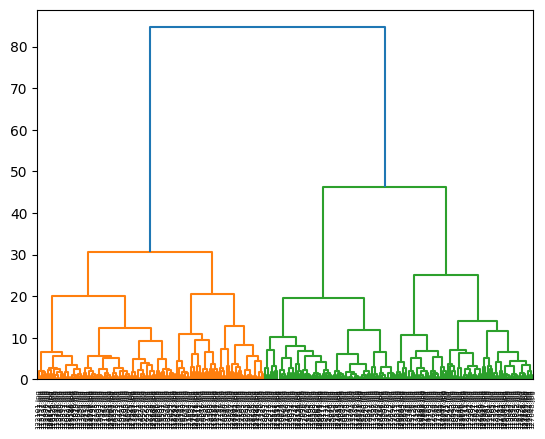

In [17]:
linked = linkage(md, method='ward')
dendrogram_result = dendrogram(linked, labels=md.index, orientation='top')
diccionari = {i:md.index[i] for i in dendrogram_result['leaves']}

import timeit

@dataclass
class Nodo:
    idx: int
    num: int
    dist: float
    ejemplo: str
    izq: 'ArBin'
    der: 'ArBin'
    total_imagenes: int = 0

@dataclass
class Img:
    idx: int
    ejemplo: str


ArBin = Union[Nodo, Img]

def creacio(n, num, linked, diccionari):
    if n < num:
        return Img(idx=n, ejemplo=diccionari[n])
    else:
        i = n - num
        izq = creacio(int(linked[i, 0]), num, linked, diccionari)
        der = creacio(int(linked[i, 1]), num, linked, diccionari)
        total_imagenes = 1 + sum_imagenes(izq) + sum_imagenes(der)
        total_imagenes -= 1  # Subtract 1 from total_imagenes
        return Nodo(idx=n, num=linked[i, 3], dist=linked[i, 2], ejemplo=izq.ejemplo, izq=izq, der=der, total_imagenes=total_imagenes)


def show(a, n):
    if isinstance(a, Img):
        print("  " * n, f"Img ({a.idx}): {a.ejemplo}")
    else:
        print("  " * n, f"Nodo ({a.idx}): {a.num} {a.dist} {a.ejemplo} Total imágenes: {a.total_imagenes}")
        show(a.izq, n + 1)
        show(a.der, n + 1)

def sum_imagenes(arbol):
    if isinstance(arbol, Nodo):
        return arbol.total_imagenes
    elif isinstance(arbol, Img):
        return 1
    else:
        return 0


def generate_df_from_tree_timing(num, linked, diccionari):
    tiempo_inicio = timeit.default_timer()
    dendrograma = creacio(num * 2 - 2, num, linked, diccionari)
    show(dendrograma, 0)
    tiempo_fin = timeit.default_timer()
    tiempo_ejecucion_segundos = tiempo_fin - tiempo_inicio

    # Convertir el tiempo de ejecución a formato hh:mm:ss
    tiempo_ejecucion_timedelta = timedelta(seconds=tiempo_ejecucion_segundos)
    tiempo_ejecucion_str = str(tiempo_ejecucion_timedelta)

    df_tiempo = pd.DataFrame({"t_creacion_dendrograma": [tiempo_ejecucion_str]}, index=[f'Iteración_{num}'])
    return df_tiempo


def get_images_from_tree(arbol):
    if isinstance(arbol, Nodo):
        images = [arbol.ejemplo]
        images += get_images_from_tree(arbol.izq)
        images += get_images_from_tree(arbol.der)
        return images
    elif isinstance(arbol, Img):
        return [arbol.ejemplo]
    else:
        return []

def generate_df_with_similarity(dendrograma, objetivo_imagenes, reference_image_path, siamese, target_size):
    arbol_cortado = cortar_arbol(dendrograma, objetivo_imagenes)
    todas_las_imagenes = get_images_from_tree(arbol_cortado)
    df_arbol = pd.DataFrame({"Imagen": todas_las_imagenes}).reset_index(drop=True)
    df_arbol = df_arbol.drop_duplicates(subset="Imagen").reset_index(drop=True)
    df_arbol['Sim'] = np.nan
    img_reference = image.load_img(reference_image_path, target_size=target_size)
    img_reference = image.img_to_array(img_reference)
    img_reference = np.expand_dims(img_reference, axis=0)

    for i, row in df_arbol.iterrows():
        image_path = f'/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/cut_faces/{row["Imagen"]}'
        img_df = image.load_img(image_path, target_size=target_size)
        img_df = image.img_to_array(img_df)
        img_df = np.expand_dims(img_df, axis=0)
        similarity = siamese.predict([img_reference, img_df])
        df_arbol.at[i, 'Sim'] =similarity[0][0]
    return df_arbol

def cortar_arbol(arbol, objetivo):
    if arbol.total_imagenes <= objetivo:
        return arbol
    elif isinstance(arbol.izq, Nodo) and arbol.izq.total_imagenes >= objetivo:
        return cortar_arbol(arbol.izq, objetivo)
    else:
        return cortar_arbol(arbol.der, objetivo)

def generate_df_from_tree(dendrograma, objetivo_imagenes):
    arbol_cortado = cortar_arbol(dendrograma, objetivo_imagenes)
    print("Cut Dendrogram (Objective Images:", objetivo_imagenes, "):")
    show(arbol_cortado, 0)
    todas_las_imagenes = get_images_from_tree(arbol_cortado)
    df_arbol = pd.DataFrame({"Imagen": todas_las_imagenes}).reset_index(drop=True)
    df_arbol = df_arbol.drop_duplicates(subset="Imagen").reset_index(drop=True)
    return df_arbol

In [18]:
num = md.shape[0]
dendrograma = creacio(num*2-2, num, linked, diccionari)
df_tiempo_creacion_dendrograma = generate_df_from_tree_timing(num, linked, diccionari)
df_tiempo_creacion_dendrograma

 Nodo (518): 260.0 84.6514644593133 122101.jpg Total imágenes: 260
   Nodo (516): 119.0 30.574365590300225 122101.jpg Total imágenes: 119
     Nodo (513): 72.0 20.051213868924336 122101.jpg Total imágenes: 72
       Nodo (494): 24.0 6.630885520694225 122101.jpg Total imágenes: 24
         Nodo (407): 5.0 1.892654350488553 122101.jpg Total imágenes: 5
           Nodo (291): 2.0 0.7748650155267442 122101.jpg Total imágenes: 2
             Img (130): 122101.jpg
             Img (154): 123757.jpg
           Nodo (397): 3.0 1.7667075026965544 115717.jpg Total imágenes: 3
             Img (2): 115717.jpg
             Nodo (343): 2.0 1.2152411468737356 118498.jpg Total imágenes: 2
               Img (56): 118498.jpg
               Img (124): 121886.jpg
         Nodo (485): 19.0 5.58030101557147 128377.jpg Total imágenes: 19
           Nodo (446): 9.0 2.7761646216553753 128377.jpg Total imágenes: 9
             Nodo (422): 3.0 2.114983212636218 128377.jpg Total imágenes: 3
               Img (

,t_creacion_dendrograma
Iteración_260,0:00:00.210362


<a id="5"></a>
## 5. Tiempo recorrido arbol

En este apartado se calcula el tiempo que se tarda en descender por el arbol, para obtener las imagenes mas similares

In [19]:
target_size = (178, 218)

In [20]:
def visualize_pair(imagen_referencia, nombre_imagen, similitud):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Similitud: {similitud}', size=16)
    img_referencia = mpimg.imread(imagen_referencia)
    ax1.imshow(img_referencia)
    ax1.set_title('Imagen de Referencia')
    ax1.axis('off')
    img_asociada = mpimg.imread(f'/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/cut_faces/{nombre_imagen}')
    ax2.imshow(img_asociada)
    ax2.set_title(f'Imagen Asociada: {nombre_imagen}')
    ax2.axis('off')

    plt.show()


def calculate_similarity_recursive(df_result, arbol, reference_image_path, siamese, target_size, threshold=0.5):
    if isinstance(arbol, Nodo):
        img_reference = image.load_img(reference_image_path, target_size=target_size)
        img_reference = image.img_to_array(img_reference)
        img_reference = np.expand_dims(img_reference, axis=0)
        image_path = os.path.join('/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/cut_faces/', arbol.ejemplo)
        img_df = image.load_img(image_path, target_size=target_size)
        img_df = image.img_to_array(img_df)
        img_df = np.expand_dims(img_df, axis=0)
        similarity = siamese.predict([img_reference, img_df])
        if similarity[0][0] <= threshold:
            df_result = calculate_similarity_recursive(df_result, arbol.izq, reference_image_path, siamese, target_size, threshold)
        else:
            df_result = calculate_similarity_recursive(df_result, arbol.der, reference_image_path, siamese, target_size, threshold)
        df_temp = pd.DataFrame({"Imagen": [arbol.ejemplo], "Similitud": [similarity[0][0]]})
        df_result = pd.concat([df_result, df_temp], ignore_index=True)
    elif isinstance(arbol, Img):
        img_reference = image.load_img(reference_image_path, target_size=target_size)
        img_reference = image.img_to_array(img_reference)
        img_reference = np.expand_dims(img_reference, axis=0)
        image_path = os.path.join('/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/cut_faces/', arbol.ejemplo)
        img_df = image.load_img(image_path, target_size=target_size)
        img_df = image.img_to_array(img_df)
        img_df = np.expand_dims(img_df, axis=0)
        similarity = siamese.predict([img_reference, img_df])
        df_temp = pd.DataFrame({"Imagen": [arbol.ejemplo], "Similitud": [similarity[0][0]]})
        df_result = pd.concat([df_result, df_temp], ignore_index=True)

    return df_result


def apply_similarity_to_tree_and_build_dataframe(dendrograma, reference_image_path, siamese, target_size, threshold=0.5):
    df_result = pd.DataFrame(columns=["Imagen", "Similitud"])
    df_result = calculate_similarity_recursive(df_result, dendrograma, reference_image_path, siamese, target_size, threshold)
    return df_result

def calculate_and_adjust_similarity(dendrograma, objetivo_imagenes, reference_image_path, siamese, target_size):
    df_with_similarity = generate_df_with_similarity(dendrograma, objetivo_imagenes, reference_image_path, siamese, target_size)
    df_with_similarity = df_with_similarity.sort_values(by='Sim', ascending=True).reset_index(drop=True)
    df_with_similarity['Sim'] = 1 - df_with_similarity['Sim']

    return df_with_similarity

def process_similarity_dataframe(dendrograma, reference_image_path, siamese, target_size):
    df_result = apply_similarity_to_tree_and_build_dataframe(dendrograma, reference_image_path, siamese, target_size)
    df_result = df_result.drop_duplicates(subset="Imagen").reset_index(drop=True)
    df_result = df_result.sort_values(by="Similitud", ascending=True).reset_index(drop=True)
    df_result["Similitud"] = 1 - df_result["Similitud"]

    return df_result

In [21]:
from datetime import timedelta
reference_image_path='/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/img_prueba/202017.jpg'
start_time_2 = time.time()
df_result_processed = process_similarity_dataframe(dendrograma, reference_image_path, siamese, target_size)
end_time_2 = time.time()
elapsed_time_2 = end_time_2 - start_time_2
elapsed_time_timedelta = timedelta(seconds=elapsed_time_2)
elapsed_time_seconds = round(elapsed_time_timedelta.total_seconds(), 1)
hours, remainder = divmod(elapsed_time_seconds, 3600)
minutes, seconds = divmod(remainder, 60)
elapsed_time_str = f"{int(hours):02}:{int(minutes):02}:{seconds:.1f}"
df_tiempo_2 = pd.DataFrame({"t_recorrido_arbol": [elapsed_time_str]})
df_tiempo_2

1/1 [==============================] - 0s 29ms/step


,t_recorrido_arbol
0,00:00:12.4


<a id="5"></a>
## 6. Tiempo total

Crear dataframe con todos los tiempos asociados a las iteraciones (numero de imagenes).

In [ ]:
values_creacion_dendrograma = df_tiempo_creacion_dendrograma.values.flatten().tolist()
values_tiempo_2 = df_tiempo_2.values.flatten().tolist()
values_list =  values_creacion_dendrograma +  values_tiempo_2
result_df = pd.DataFrame({
    't_creacion_dendrograma': values_creacion_dendrograma,
    't_recorrido_arbol': values_tiempo_2
}, index=[f'Iteración_{num_imagenes_a_comparar}'])
result_df

In [ ]:
result_df.to_csv(f'/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/tope_imagenes/tiempo_{num_imagenes_a_comparar}.txt', sep='\t', index=True)

In [ ]:
file_path4 = f'/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/tope_imagenes/tiempo_{num_imagenes_a_comparar}.txt'
loaded_df = pd.read_csv(file_path4, sep='\t',index_col=0)
loaded_df

<a id="7"></a>
## 7. Tabla de tiempo / Iteración

Creación tabla de tiempos de ejecución unidos

In [33]:
file_path = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/tope_imagenes/'
numeros = [50, 100, 200, 250, 260]
archivos_txt = [f'tiempo_{numero}.txt' for numero in numeros]
dataframes = []
for archivo in archivos_txt:
    ruta_completa = os.path.join(file_path, archivo)
    df = pd.read_csv(ruta_completa, delimiter='\t', index_col=0)
    dataframes.append(df)
df_final = pd.concat(dataframes, axis=0, ignore_index=False)
df_final

,t_matriz,t_creacion_dendrograma,t_recorrido_arbol
Iteración_50,0:02:57.990000,0:00:00.038648,00:00:1.3
Iteración_100,0:09:55.940000,0:00:00.057738,00:00:0.7
Iteración_200,0:42:17.400000,0:00:00.141169,00:00:1.1
Iteración_250,1:05:05.560000,0:00:00.207742,00:00:3.0
Iteración_260,1:19:13.470000,0:00:00.210362,00:00:12.4
